In [ ]:
#default_exp labelling.levels

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Topological levels
> Defining topological levels, and describing their characteristics

## Definition of forward and backward topological levels

The **backward topological level** of a vertex $v$ (denoted as $l_v$) can be defined as its depth:
- if $v$ has no immediate predecessors (has no outgoing edges, i.e. its out-degree is zero - it is a **_sink_**),  
  then $l_v = 0$,
- otherwise it is maximum of levels of its immediate predecessors plus one:  
  $l_v = \max\limits_{u\colon (v,u)\in E}(l_u)+1$.

In other words it is the maximum length of any path starting from vertex $v$.

The backward topological level increases at least by one when going in the opposite direction to edges (going backwards).

> Note: This reachability label is _immutable_ with respect to the graph growth by adding nodes.

----

The **forward topological level** of a vertex $v$ (denoted as $L_v$) is defined in the following way:
- if $v$ has no immediate parents / successors (it has no in-going edges, i.e. its in-degree is zero -- it is a **_source_**),  
  then $L_v = 0$,
- otherwise it is maximum of forward levels of its immediate successors plus one,  
  that is $L_v = \max\limits_{u\colon (u,v)\in E}(L_u + 1)$

In other words it is maximum length of any path ending at vertex $v$.

The forward topological level increases by at least one when going in the direction of edge (going forwards).

The image below shows an example directed graph (DAG), marked with forward and backward topological levels (forward marked in green and backward marked in blue).  This example is taken from the Figure 2 in the PReaCH paper.

![Forward and backward topological levels for an example graph](images/preach/PReaCH_arXiv-fig_2-forward_and_backward_topological_levels-zoom.png)

## Properties of topological levels

The forward level $L_v$ of a vertex induces its topological ordering: if $u$ precedes $v$ in the topological ordering of DAG $G$ and $u \neq v$, then $L_u < L_v$.

> Note: the alternative notation for $l_u$ is $l(u)$, and for $L_u$ is $L(u)$.

In other words the following observation holds:

- for **forward topological levels** (defined as having level equal 0 for ***source nodes***):
  $$\forall u \neq v \in V : L(u) \geq L(v) \implies u \nrightarrow v $$
  
- for **backward topological levels** (defined as having level equal 0 for ***sink nodes***):
  $$\forall u \neq v \in V : l(u) \leq l(v) \implies u \nrightarrow v $$

We can also use a _weaker_ condition, which has the advantage of avoiding corner cases of checking whether $u = v$ / $u \neq v$:

- for **forward topological levels** (defined as having level equal 0 for ***source nodes***):
  $$\forall u \in V, v \in V : L(u) > L(v) \implies u \nrightarrow v $$
  
- for **backward topological levels** (defined as having level equal 0 for ***sink nodes***):
  $$\forall u \in V, v \in V : l(u) < l(v) \implies u \nrightarrow v $$
  
It also helps in the case where newer commits do not have backward topological levels computed, and we want to use topological levels even in the case where at least one vertex in reachability query is new.

All this means that both forward and backward topological levels can function as **negative-cut filter** (reducing the search space).

## Computing backward topological levels

In [ ]:
#export
import networkx as nx


> <u>Definition:</u> The **level** of a vertex $v$ (denoted as $l_v$) can be defined as its depth: if $v$ has no immediate predecessors, then $l_v = 0$, otherwise it is maximum of levels of its immediate predecessors plus one: $$l_v = \max\limits_{u\colon (v,u)\in E}(l_u)+1$$

In [ ]:
#export
def find_levels(DG, attr=None):
  """Find levels (generation number) of all vertices in graph G
  
  The backward topological level of a vertex v, which we denote as l_v or l(v),
  can be defined as its depth, or the length of longestt path
  to the leaf (sink) node.
  
   - if v has no immediate predecessors, then l_v = 0
   - otherwise l_v = 1 + max_{u: predecessors}(l_u)
  
  The levels / generation number information can be optionally saved in
  the graph, under given node attribute (name given by `attr` parameter).
  
  NOTE: whether for nodes without outcoming edges (without any neighbours)
  l_v is defined to be 0, or defined to be 1, is a matter of convention.
  Here the same convention as in the FELINE paper is used.
  
  NOTE: for compatibility with forward topological levels sometimes
  backward topological levels are used with negative sign applied,
  like in the PReaCH paper.
  
  Parameters:
  -----------
  DG : NetworkX DiGraph
      Directed acyclic graph.
      
  attr : str, optional (default=None)
      If set, name of a node attribute under which store vertex level.
      
  Returns:
  --------
  dict of ints
      Dictionary, where keys are node indices, and values are node levels
  """
  lvl = {}
  
  # topological levels are defined only for Directed Acyclic Graphs
  if not DG.is_directed():
    raise nx.NetworkXNotImplemented(
      "Vertex level is not defined on undirected graphs.")
  if not nx.is_directed_acyclic_graph(DG):
    raise nx.NetworkXNotImplemented(
      "Vertex level is not defined on directed graphs with loops")
  
  # it can be any post-order ordering
  nodelist = nx.dfs_postorder_nodes(DG)
  for node in nodelist:
    if DG.out_degree(node) == 0:
      lvl[node] = 0
      continue
    
    lvl[node] = max([lvl[neigh] 
                     for neigh in DG.successors(node)]) + 1
  
  if attr is not None:
    for node, level in lvl.items():
      DG.nodes[node][attr] = level
  
  return lvl


### Test `find_levels(graph)`

Test that `find_levels()` works on known example graphs from [example_graphs](03_example_graphs.ipynb)

In [ ]:
# this is needed only for demonstrations
import matplotlib.pyplot as plt
import git_commit_graph_ext.example_graphs as graphs

Use the small DAG from the FELINE paper as a test

In [ ]:
sd=graphs.small_DAG_FELINE()
find_levels(sd)

{'h': 0, 'c': 1, 'd': 0, 'e': 1, 'a': 2, 'f': 1, 'g': 0, 'b': 2}

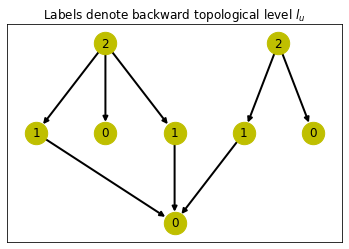

In [ ]:
sd=graphs.small_DAG_FELINE()
sd.lvl=find_levels(sd)
sd.pos={'a':(2,3),'b':(4.5,3),'c':(1,2),'d':(2,2),'e':(3,2),'f':(4,2),'g':(5,2),'h':(3,1)}

nx.draw_networkx(sd, pos=sd.pos,
                 with_labels=False,
                 node_size=500,width=2.0,node_color='y')
nx.draw_networkx_labels(sd, pos=sd.pos,
                        labels=sd.lvl)

plt.title('Labels denote backward topological level $l_u$')
plt.draw()

Use the graph from Figure 9 in the FELINE paper

In [ ]:
lf=graphs.levels_DAG_FELINE()
assert find_levels(lf) == {
    'c':0,'g':0,'h':0,'i':0,
    'd':1,'e':1,'f':1,
    'a':2,'b':2
}

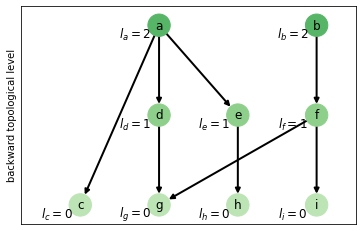

In [ ]:
lf=graphs.levels_DAG_FELINE()
# backward level
lf.lvl_expected={
    'c':0,'g':0,'h':0,'i':0,
    'd':1,'e':1,'f':1,
    'a':2,'b':2
}
lf.lvl=find_levels(lf)
# positions of nodes
lf.tree={
  'a':(2,2),'b':(4,2),
  'd':(2,1),'e':(3,1),'f':(4,1),
  'c':(1,0),'g':(2,0),'h':(3,0),'i':(4,0)
}
# configure plot
#plt.axis('off')
plt.ylabel('backward topological level')
#plt.subplots_adjust(left=0,right=1.2)
plt.xlim(left=0.25,right=4.5)
nx.draw_networkx(lf,
                 pos=lf.tree,
                 nodelist=list(lf.lvl.keys()),
                 node_color=list(lf.lvl.values()),
                 cmap=plt.cm.Greens,
                 vmin=-2,vmax=5,
                 node_size=500,width=2.0)
nx.draw_networkx_labels(lf,
                        pos={k: (v[0]-0.3,v[1]-0.1) for (k,v) in lf.tree.items()},
                        labels={k:'$l_'+str(k)+'='+str(l)+'$'
                                for (k,l) in lf.lvl.items()})
plt.draw()

**TODO:** Interactive visualization

----

In [ ]:
#hide
# this should be the last cell of the notebook
from nbdev.export import notebook2script
notebook2script()

Converted 01_tools.ipynb.
Converted 02_related.ipynb.
Converted 03_example_graphs.ipynb.
Converted 04_reachability_index.ipynb.
Converted 05_levels.ipynb.
Converted index.ipynb.
